Ayesh Madushanka Mahamada Kalapuwage

### **Lab: Style Transfer**

# Q1 Train two (or more) image decoders that can decode an image from two different convolutional layers from VGG (or whatever network you want).  You should choose one reconstruction from an early layer (like block 1 or 2 in VGG) and from a later layer (like block 3 or later in VGG)

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Seed control, for better reproducibility
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    # generator.cuda()
    # discriminator.cuda()
    # adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor

print(device)

#EPOCHS = 500

cpu


In [ ]:
def imshow(img):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch_size = 250 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

dataset = dset.CIFAR10(root='data/cifar/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

# frogs are the sixth class in the dataset
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
frog = [0]
frog_index = [i for i, x in enumerate(dataset.targets) if x in frog]
print("number of frog imgs: ", len(frog_index))

frog_set = torch.utils.data.Subset(dataset, frog_index)


dataloader_train = torch.utils.data.DataLoader(frog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=1)



Files already downloaded and verified
number of frog imgs:  5000


In [ ]:
dataloader_test = torch.utils.data.DataLoader(frog_set, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

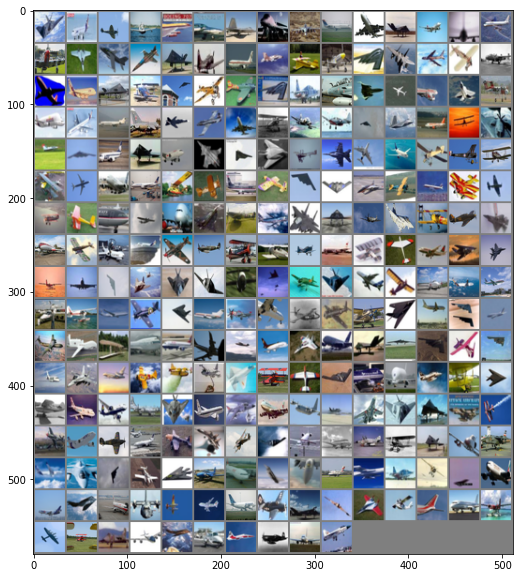

Image shape:  torch.Size([3, 32, 32])


In [ ]:
# get some random training images
dataiter = iter(dataloader_train)
real_image_examples, _ = dataiter.next()

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(real_image_examples, nrow=int(np.sqrt(batch_size))))
print("Image shape: ", real_image_examples[0].size())

In [ ]:
CUDA_DEVICE_NUM = 3
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
batch_size = 32
NUM_EPOCHS = 50

Device: cpu


In [ ]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        #print(x.shape, skip.shape)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        #self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        #self.b = conv_block(512, 1024)
        self.b = conv_block(256, 512)

        """ Decoder """
        #self.d1 = decoder_block(1024, 512)
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        #s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p3)

        """ Decoder """
        #d1 = self.d1(b, s4)
        d1 = self.d1(b, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)

        """ Classifier """
        outputs = self.outputs(d3)

        return outputs

if __name__ == "__main__":
    # inputs = torch.randn((2, 32, 256, 256))
    # e = encoder_block(32, 64)
    # x, p = e(inputs)
    # print(x.shape, p.shape)
    #
    # d = decoder_block(64, 32)
    # y = d(p, x)
    # print(y.shape)

    #inputs = torch.randn((2, 1, 64, 64))
    model = build_unet()
    #y = model(inputs)



In [ ]:
model = build_unet()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
import time
import torch
import torch.nn.functional as F

from collections import OrderedDict
import json
import subprocess
import sys
import xml.etree.ElementTree


def train_classifier_simple_v1(num_epochs, model, optimizer, device,
                               dataloader_train, valid_loader=None,
                               loss_fn=None, logging_interval=100,
                               skip_epoch_stats=False):

    log_dict = {'train_loss_per_batch': [],
                'train_acc_per_epoch': [],
                'train_loss_per_epoch': [],
                'valid_acc_per_epoch': [],
                'valid_loss_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(dataloader_train):

            features = features.to(device)
            targets = targets.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            loss = loss_fn(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(dataloader_train), loss))

        if not skip_epoch_stats:
            model.eval()



            with torch.set_grad_enabled(False):  # save memory during inference

                train_acc = compute_accuracy(model, dataloader_train, device)
                train_loss = compute_epoch_loss_classifier(
                    model, dataloader_train, loss_fn, device)
                print('***Epoch: %03d/%03d | Train. Acc.: %.3f%% | Loss: %.3f' % (
                      epoch+1, num_epochs, train_acc, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())
                log_dict['train_acc_per_epoch'].append(train_acc.item())

                if valid_loader is not None:
                    valid_acc = compute_accuracy(model, valid_loader, device)
                    valid_loss = compute_epoch_loss_classifier(
                        model, valid_loader, loss_fn, device)
                    print('***Epoch: %03d/%03d | Valid. Acc.: %.3f%% | Loss: %.3f' % (
                          epoch+1, num_epochs, valid_acc, valid_loss))
                    log_dict['valid_loss_per_epoch'].append(valid_loss.item())
                    log_dict['valid_acc_per_epoch'].append(valid_acc.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    return log_dict


def train_autoencoder_v1(num_epochs, model, optimizer, device,
                         dataloader_train, loss_fn=None,
                         logging_interval=100,
                         skip_epoch_stats=False,
                         save_model=None):

    log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(dataloader_train):

            features = features.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            loss = loss_fn(logits, features)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(dataloader_train), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_loss = compute_epoch_loss_autoencoder(
                    model, dataloader_train, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict


def train_vae_v1(num_epochs, model, optimizer, device,
                 dataloader_train, loss_fn=None,
                 logging_interval=100,
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):

    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(dataloader_train):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)

            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 +
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var
                                      - z_mean**2
                                      - torch.exp(z_log_var),
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension

            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension

            loss = reconstruction_term_weight*pixelwise + kl_div

            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(dataloader_train), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_loss = compute_epoch_loss_autoencoder(
                    model, dataloader_train, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [ ]:
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model,
                                optimizer=optimizer, device=DEVICE,
                                dataloader_train=dataloader_train,
                                skip_epoch_stats=True,
                                logging_interval=250)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Using a target size (torch.Size([250, 3, 32, 32])) that is different to the input size (torch.Size([250, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 001/050 | Batch 0000/0020 | Loss: 0.3169
Time elapsed: 6.08 min
Epoch: 002/050 | Batch 0000/0020 | Loss: 0.0451
Time elapsed: 12.17 min
Epoch: 003/050 | Batch 0000/0020 | Loss: 0.0326
Time elapsed: 18.38 min
Epoch: 004/050 | Batch 0000/0020 | Loss: 0.0313
Time elapsed: 24.48 min
Epoch: 005/050 | Batch 0000/0020 | Loss: 0.0325
Time elapsed: 30.65 min
Epoch: 006/050 | Batch 0000/0020 | Loss: 0.0334
Time elapsed: 36.77 min
Epoch: 007/050 | Batch 0000/0020 | Loss: 0.0300
Time elapsed: 42.99 min
Epoch: 008/050 | Batch 0000/0020 | Loss: 0.0318
Time elapsed: 49.19 min
Epoch: 009/050 | Batch 0000/0020 | Loss: 0.0352
Time elapsed: 55.47 min
Epoch: 010/050 | Batch 0000/0020 | Loss: 0.0298
Time elapsed: 61.68 min
Epoch: 011/050 | Batch 0000/0020 | Loss: 0.0305
Time elapsed: 67.85 min
Epoch: 012/050 | Batch 0000/0020 | Loss: 0.0321
Time elapsed: 74.01 min
Epoch: 013/050 | Batch 0000/0020 | Loss: 0.0300
Time elapsed: 80.24 min
Epoch: 014/050 | Batch 0000/0020 | Loss: 0.0345
Time elapsed: 86.

In [ ]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()


def plot_accuracy(train_acc, valid_acc):

    num_epochs = len(train_acc)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

ValueError: ignored

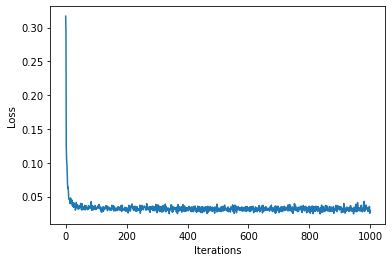

In [ ]:
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

I used a Unet structure which includes 2 convolusion layers. I used 3 image decorer from this 2 convolusion layers. training is converged on 100 epochs but I have run it for 1000. I kept this in overnight.

I used cifar dataset (flight) images for the autoencoder training which includes 5000 images, and the error in the graph because the loss is almost zero. L2 loss and back propagation are occupied.




